<a href="https://colab.research.google.com/github/franckhuberson/API-SCRAPING/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# ============================================================
# 1. INTRODUCTION ET PROBLÉMATIQUE
# ============================================================

print("=" * 80)
print("1. INTRODUCTION ET PROBLÉMATIQUE")
print("=" * 80)

print("""
CONTEXTE :
----------
Le blanchiment d'argent représente un fléau économique mondial, avec des
estimations du FMI atteignant 2 à 5% du PIB mondial, soit 800 milliards à
2 billions de dollars par an.

PROBLÉMATIQUE :
--------------
Comment détecter automatiquement les transactions suspectes parmi des
millions d'opérations légitimes, avec un taux de faux positifs acceptable
et un taux de détection suffisant ?

DÉFIS MAJEURS :
--------------
• Déséquilibre extrême des classes (< 0.2% de transactions suspectes)
• Volume massif de données (plus d'1 million de transactions)
• Évolution constante des techniques de blanchiment
• Nécessité d'explicabilité pour les enquêteurs

OBJECTIFS DU MÉMOIRE :
--------------------
1. Évaluer les performances de différents algorithmes sur AMLNet
2. Optimiser la gestion du déséquilibre des classes
3. Proposer un modèle opérationnel avec un bon compromis recall/précision
4. Comparer avec les résultats de l'état de l'art (F1-Score > 0.85)
""")

1. INTRODUCTION ET PROBLÉMATIQUE

CONTEXTE :
----------
Le blanchiment d'argent représente un fléau économique mondial, avec des
estimations du FMI atteignant 2 à 5% du PIB mondial, soit 800 milliards à
2 billions de dollars par an.

PROBLÉMATIQUE :
--------------
Comment détecter automatiquement les transactions suspectes parmi des
millions d'opérations légitimes, avec un taux de faux positifs acceptable
et un taux de détection suffisant ?

DÉFIS MAJEURS :
--------------
• Déséquilibre extrême des classes (< 0.2% de transactions suspectes)
• Volume massif de données (plus d'1 million de transactions)
• Évolution constante des techniques de blanchiment
• Nécessité d'explicabilité pour les enquêteurs

OBJECTIFS DU MÉMOIRE :
--------------------
1. Évaluer les performances de différents algorithmes sur AMLNet
2. Optimiser la gestion du déséquilibre des classes
3. Proposer un modèle opérationnel avec un bon compromis recall/précision
4. Comparer avec les résultats de l'état de l'art (F1-S

In [69]:
# ============================================================
# IMPORT DES BIBLIOTHÈQUES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              IsolationForest)
from sklearn.tree import DecisionTreeClassifier

# XGBoost
import xgboost as xgb

# Traitement du déséquilibre
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


In [71]:
# ============================================================
# 2. PRÉSENTATION DU DATASET AMLNET
# ============================================================

print("\n" + "=" * 80)
print("2. PRÉSENTATION DU DATASET AMLNET")
print("=" * 80)

# Chargement du dataset
df = pd.read_csv("AMLNet_August 2025.csv", engine='python')  # Adapter le nom exact du fichier

print(f"\n📊 INFORMATIONS GÉNÉRALES :")
print(f"  • Fichier : AMLNet_August 2025")
print(f"  • Dimensions : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"  • Taille mémoire : {df.memory_usage(deep=True).sum() / 1024**2:.2f} Mo")

print("\n📋 APERÇU DES DONNÉES :")
display(df.head())

print("\n🔍 INFORMATIONS SUR LES COLONNES :")
info_df = pd.DataFrame({
    'Colonne': df.columns,
    'Type': df.dtypes.values,
    'Non-Null': df.count().values,
    'Null (%)': (df.isnull().sum().values / len(df) * 100).round(2),
    'Cardinalité': [df[col].nunique() for col in df.columns]
})
display(info_df)


2. PRÉSENTATION DU DATASET AMLNET

📊 INFORMATIONS GÉNÉRALES :
  • Fichier : AMLNet_August 2025
  • Dimensions : 66,224 lignes × 17 colonnes
  • Taille mémoire : 58.85 Mo

📋 APERÇU DES DONNÉES :


,step,type,amount,category,nameOrig,nameDest,oldbalanceOrg,newbalanceOrig,isFraud,isMoneyLaundering,laundering_typology,metadata,fraud_probability,hour,day_of_week,day_of_month,month
0,0,DEBIT,298.8420,Other,C8083,C7053,455489.3216,455190.4795,0.0000,0.0000,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12.0000,1.0000,4.0000,2.0000
1,0,DEBIT,93.0879,Recreation,C5575,C1117,229508.2912,229415.2033,0.0000,0.0000,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12.0000,1.0000,4.0000,2.0000
2,0,EFTPOS,155.6449,Healthcare,C1549,C1423,202568.8069,202413.1620,0.0000,0.0000,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12.0000,1.0000,4.0000,2.0000
3,0,BPAY,299.7591,Food,C7435,C6390,491560.6002,491260.8411,0.0000,0.0000,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12.0000,1.0000,4.0000,2.0000
4,0,DEBIT,173.7156,Other,C8083,C5946,455190.4795,455016.7639,0.0000,0.0000,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12.0000,1.0000,4.0000,2.0000



🔍 INFORMATIONS SUR LES COLONNES :


,Colonne,Type,Non-Null,Null (%),Cardinalité
0,step,int64,66224,0.0000,1
1,type,object,66224,0.0000,8
2,amount,float64,66224,0.0000,66224
3,category,object,66224,0.0000,10
4,nameOrig,object,66224,0.0000,9417
5,nameDest,object,66224,0.0000,10634
6,oldbalanceOrg,float64,66224,0.0000,66224
7,newbalanceOrig,float64,66224,0.0000,66224
8,isFraud,float64,66223,0.0000,2
9,isMoneyLaundering,float64,66223,0.0000,2


In [72]:
# ============================================================
# 2.1. Description des variables
# ============================================================

print("\n" + "-" * 60)
print("2.1. DESCRIPTION DES VARIABLES")
print("-" * 60)

print("""
VARIABLES EXPLICATIVES :
------------------------
• step : Unité de temps (1 heure par step)
• type : Type de transaction (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
• amount : Montant de la transaction
• nameOrig : Identifiant du compte émetteur
• oldbalanceOrg : Solde avant transaction du compte émetteur
• newbalanceOrig : Solde après transaction du compte émetteur
• nameDest : Identifiant du compte destinataire
• oldbalanceDest : Solde avant transaction du compte destinataire
• newbalanceDest : Solde après transaction du compte destinataire
• hour : Heure de la transaction
• day_of_week : Jour de la semaine
• day_of_month : Jour du mois
• month : Mois

VARIABLES CIBLES :
-----------------
• isFraud : Transaction frauduleuse (0/1)
• isMoneyLaundering : Transaction suspecte de blanchiment (0/1)
• category : Typologie de blanchiment (20+ catégories)
""")


------------------------------------------------------------
2.1. DESCRIPTION DES VARIABLES
------------------------------------------------------------

VARIABLES EXPLICATIVES :
------------------------
• step : Unité de temps (1 heure par step)
• type : Type de transaction (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
• amount : Montant de la transaction
• nameOrig : Identifiant du compte émetteur
• oldbalanceOrg : Solde avant transaction du compte émetteur
• newbalanceOrig : Solde après transaction du compte émetteur
• nameDest : Identifiant du compte destinataire
• oldbalanceDest : Solde avant transaction du compte destinataire
• newbalanceDest : Solde après transaction du compte destinataire
• hour : Heure de la transaction
• day_of_week : Jour de la semaine
• day_of_month : Jour du mois
• month : Mois

VARIABLES CIBLES :
-----------------
• isFraud : Transaction frauduleuse (0/1)
• isMoneyLaundering : Transaction suspecte de blanchiment (0/1)
• category : Typologie de blanchimen

In [73]:
# ============================================================
# 2.2. Comparaison avec l'état de l'art
# ============================================================

print("\n" + "-" * 60)
print("2.2. COMPARAISON AVEC L'ÉTAT DE L'ART")
print("-" * 60)

comparison_data = {
    'Dataset': ['SAML-D', 'AMLNet', 'AMLWorld', 'IBM Transactions'],
    'Transactions': ['9.5M', '1.09M', '1.2M', '1.0M'],
    'Features': ['12', '16', '14', '13'],
    'Typologies': ['28', '20+', '15+', '12+'],
    'Alignement Réglementaire': ['Non', '75% AUSTRAC', 'Partiel', 'Non'],
    'F1-Score (littérature)': ['0.075', '0.90', '0.45', '0.38']
}

comparison_df = pd.DataFrame(comparison_data)
print("📊 COMPARAISON DES DATASETS AML :")
display(comparison_df)

print("\n" + "=" * 60)
print("AMLNet se distingue par :")
print("  ✓ Alignement réglementaire AUSTRAC (75%)")
print("  ✓ Richesse des typologies de blanchiment")
print("  ✓ Performances validées dans la littérature (F1=0.90)")
print("=" * 60)


------------------------------------------------------------
2.2. COMPARAISON AVEC L'ÉTAT DE L'ART
------------------------------------------------------------
📊 COMPARAISON DES DATASETS AML :


,Dataset,Transactions,Features,Typologies,Alignement Réglementaire,F1-Score (littérature)
0,SAML-D,9.5M,12,28,Non,0.075
1,AMLNet,1.09M,16,20+,75% AUSTRAC,0.90
2,AMLWorld,1.2M,14,15+,Partiel,0.45
3,IBM Transactions,1.0M,13,12+,Non,0.38



AMLNet se distingue par :
  ✓ Alignement réglementaire AUSTRAC (75%)
  ✓ Richesse des typologies de blanchiment
  ✓ Performances validées dans la littérature (F1=0.90)


In [74]:
# ============================================================
# 3. ANALYSE EXPLORATOIRE DES DONNÉES
# ============================================================

print("\n" + "=" * 80)
print("3. ANALYSE EXPLORATOIRE DES DONNÉES")
print("=" * 80)


3. ANALYSE EXPLORATOIRE DES DONNÉES



------------------------------------------------------------
3.1. DISTRIBUTION DE LA VARIABLE CIBLE
------------------------------------------------------------
📊 Distribution de isMoneyLaundering :


,Classe,Effectif,Pourcentage
0,Normal (0),"66,077",99.7795%
1,Suspect (1),146,0.2205%


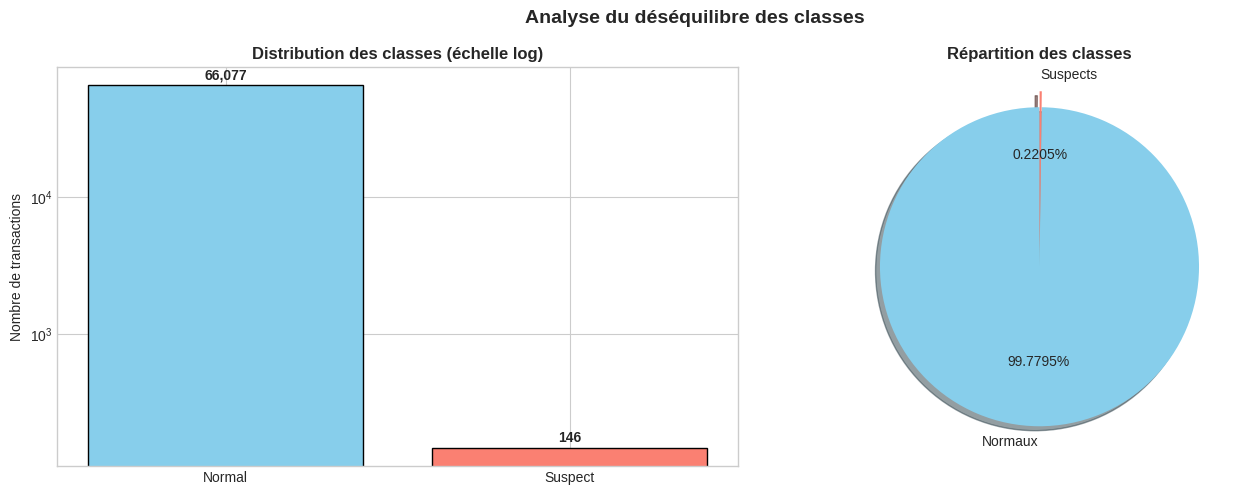


🔍 TAUX DE SUSPICION : 0.2205%
   → Déséquilibre extrême : 1 transaction suspecte pour 453 normales


In [75]:
# ============================================================
# 3.1. Distribution de la variable cible
# ============================================================

print("\n" + "-" * 60)
print("3.1. DISTRIBUTION DE LA VARIABLE CIBLE")
print("-" * 60)

# Analyse de la variable cible
target_col = 'isMoneyLaundering'  # À adapter selon le nom exact
if target_col not in df.columns:
    target_col = 'isFraud'  # Alternative

target_dist = df[target_col].value_counts().sort_index()
target_perc = df[target_col].value_counts(normalize=True).sort_index() * 100

print(f"📊 Distribution de {target_col} :")
dist_df = pd.DataFrame({
    'Classe': ['Normal (0)', 'Suspect (1)'],
    'Effectif': [f"{target_dist[0]:,}", f"{target_dist[1]:,}"],
    'Pourcentage': [f"{target_perc[0]:.4f}%", f"{target_perc[1]:.4f}%"]
})
display(dist_df)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
axes[0].bar(['Normal', 'Suspect'], [target_dist[0], target_dist[1]],
            color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_yscale('log')
axes[0].set_title('Distribution des classes (échelle log)', fontweight='bold')
axes[0].set_ylabel('Nombre de transactions')
for i, v in enumerate([target_dist[0], target_dist[1]]):
    axes[0].text(i, v * 1.1, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ['skyblue', 'salmon']
explode = (0, 0.1)
axes[1].pie([target_dist[0], target_dist[1]], explode=explode,
            labels=['Normaux', 'Suspects'], colors=colors,
            autopct='%1.4f%%', startangle=90, shadow=True)
axes[1].set_title('Répartition des classes', fontweight='bold')

plt.suptitle('Analyse du déséquilibre des classes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n🔍 TAUX DE SUSPICION : {target_perc[1]:.4f}%")
print(f"   → Déséquilibre extrême : 1 transaction suspecte pour {target_dist[0]/target_dist[1]:.0f} normales")


------------------------------------------------------------
3.2. ANALYSE DES VARIABLES NUMÉRIQUES
------------------------------------------------------------
📊 Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,95%,max
step,66224.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
amount,66224.0000,644.1300,1552.4300,13.0100,104.7000,166.8600,371.8400,2982.4900,157721.9200
oldbalanceOrg,66224.0000,343211.1900,87404.3000,16513.0800,267287.1400,345674.5500,419010.6900,476897.5400,499618.9700
newbalanceOrig,66224.0000,342567.0600,87442.3300,16422.6300,266740.4000,345049.6600,418168.5200,476344.2400,499400.5300
isFraud,66223.0000,0.0000,0.0500,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
fraud_probability,56223.0000,0.0300,0.0400,0.0000,0.0000,0.0000,0.0500,0.0600,0.9400
hour,66223.0000,11.4800,6.9300,0.0000,5.0000,12.0000,18.0000,22.0000,23.0000
day_of_week,66223.0000,2.2500,1.5300,0.0000,1.0000,2.0000,3.0000,5.0000,6.0000
day_of_month,66223.0000,8.4400,3.1100,4.0000,6.0000,8.0000,11.0000,13.0000,28.0000
month,66223.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000


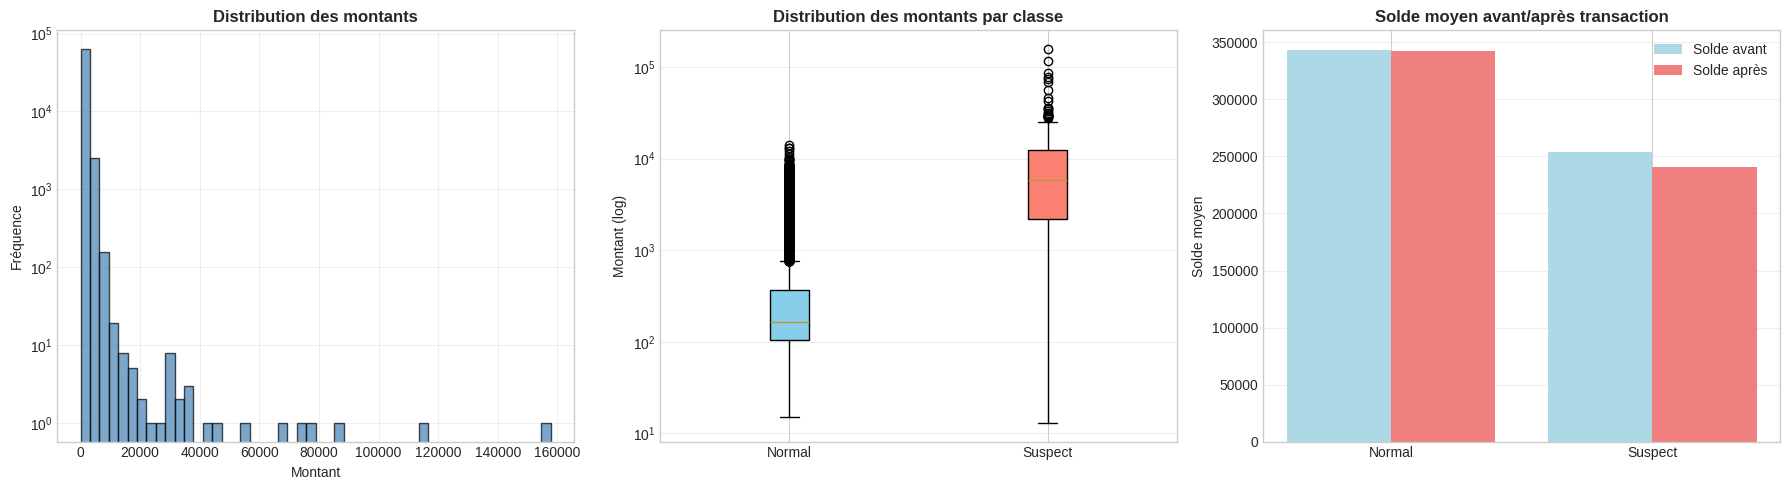

In [76]:
# ============================================================
# 3.2. Analyse des variables numériques
# ============================================================

print("\n" + "-" * 60)
print("3.2. ANALYSE DES VARIABLES NUMÉRIQUES")
print("-" * 60)

# Sélection des variables numériques
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != target_col]

print(f"📊 Statistiques descriptives :")
stats_df = df[numeric_cols].describe(percentiles=[.25, .5, .75, .95]).T
display(stats_df.round(2))

# Analyse du montant par classe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution du montant
axes[0].hist(df['amount'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des montants', fontweight='bold')
axes[0].set_xlabel('Montant')
axes[0].set_ylabel('Fréquence')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Boxplot du montant par classe
df_box = df.copy()
df_box['Classe'] = df_box[target_col].map({0: 'Normal', 1: 'Suspect'})
bp = axes[1].boxplot([df_box[df_box['Classe'] == 'Normal']['amount'],
                       df_box[df_box['Classe'] == 'Suspect']['amount']],
                      labels=['Normal', 'Suspect'], patch_artist=True)
bp['boxes'][0].set_facecolor('skyblue')
bp['boxes'][1].set_facecolor('salmon')
axes[1].set_yscale('log')
axes[1].set_title('Distribution des montants par classe', fontweight='bold')
axes[1].set_ylabel('Montant (log)')
axes[1].grid(axis='y', alpha=0.3)

# Solde moyen par classe
avg_balance = df.groupby(target_col)[['oldbalanceOrg', 'newbalanceOrig']].mean()
x = np.arange(2)
axes[2].bar(x - 0.2, avg_balance['oldbalanceOrg'], 0.4, label='Solde avant', color='lightblue')
axes[2].bar(x + 0.2, avg_balance['newbalanceOrig'], 0.4, label='Solde après', color='lightcoral')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Normal', 'Suspect'])
axes[2].set_title('Solde moyen avant/après transaction', fontweight='bold')
axes[2].set_ylabel('Solde moyen')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


------------------------------------------------------------
3.3. ANALYSE TEMPORELLE
------------------------------------------------------------
Colonnes temporelles disponibles : ['hour', 'day_of_week', 'day_of_month', 'month']


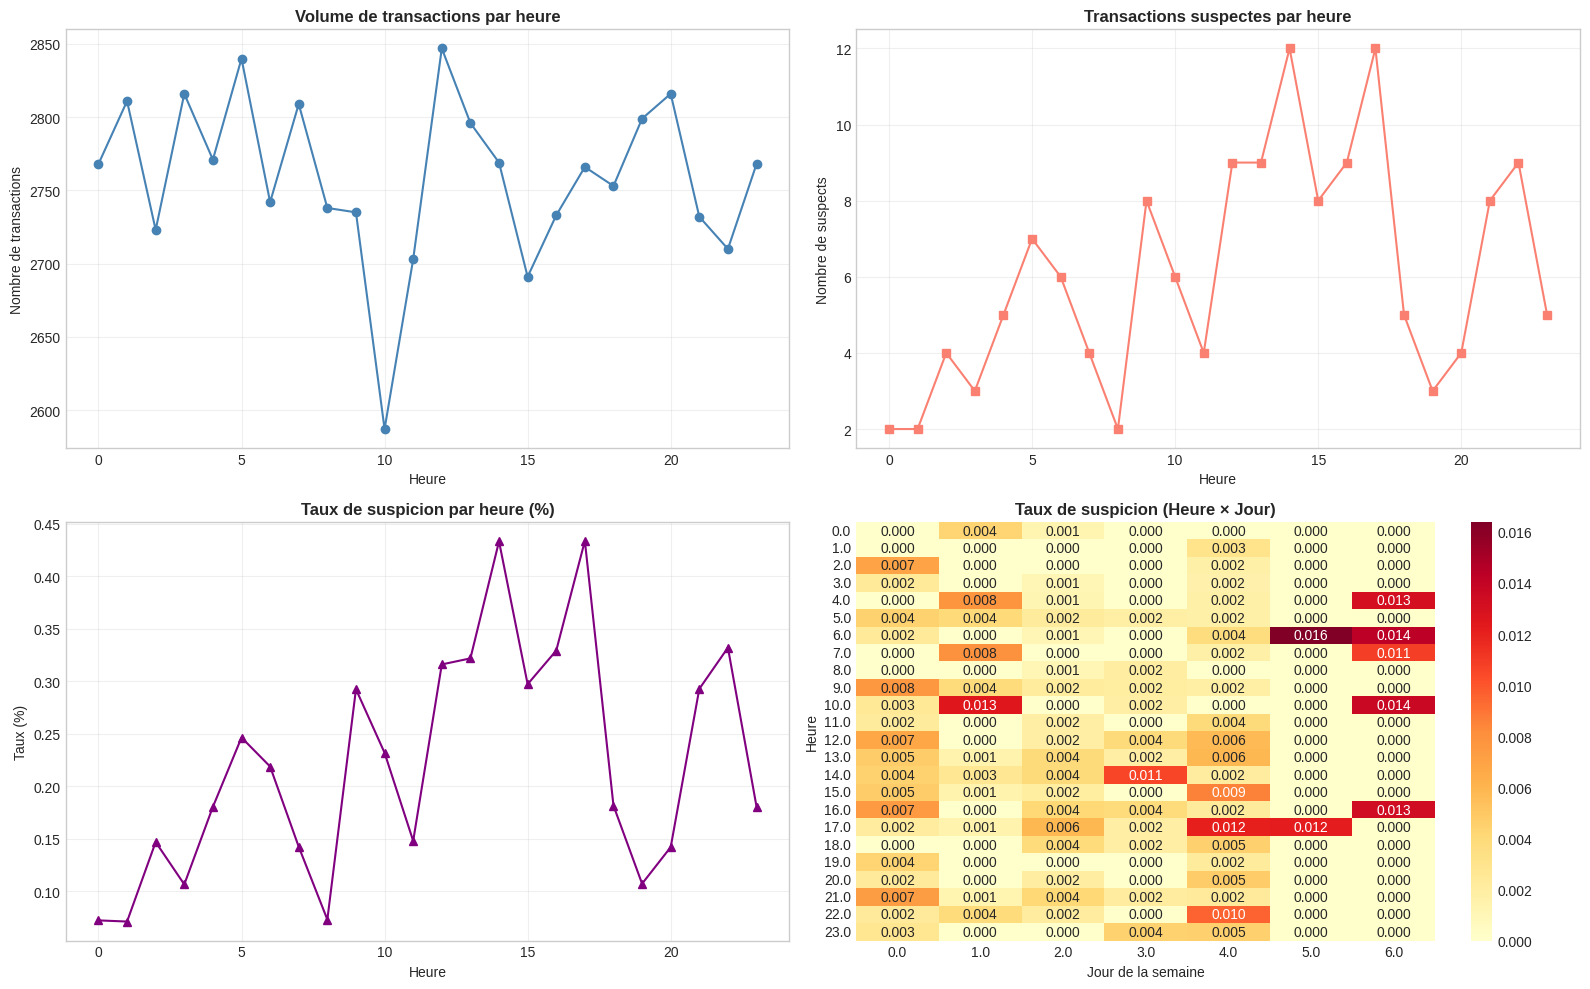

In [77]:
# ============================================================
# 3.3. Analyse temporelle
# ============================================================

print("\n" + "-" * 60)
print("3.3. ANALYSE TEMPORELLE")
print("-" * 60)

# Vérification des colonnes temporelles disponibles
time_cols = [col for col in df.columns if any(x in col.lower() for x in ['hour', 'day', 'week', 'month'])]
print(f"Colonnes temporelles disponibles : {time_cols}")

if 'hour' in df.columns:
    # Analyse par heure
    hourly_stats = df.groupby('hour')[target_col].agg(['count', 'sum', 'mean'])
    hourly_stats.columns = ['Total', 'Suspectes', 'Taux']

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Volume par heure
    axes[0, 0].plot(hourly_stats.index, hourly_stats['Total'], marker='o', color='steelblue')
    axes[0, 0].set_title('Volume de transactions par heure', fontweight='bold')
    axes[0, 0].set_xlabel('Heure')
    axes[0, 0].set_ylabel('Nombre de transactions')
    axes[0, 0].grid(alpha=0.3)

    # Suspects par heure
    axes[0, 1].plot(hourly_stats.index, hourly_stats['Suspectes'], marker='s', color='salmon')
    axes[0, 1].set_title('Transactions suspectes par heure', fontweight='bold')
    axes[0, 1].set_xlabel('Heure')
    axes[0, 1].set_ylabel('Nombre de suspects')
    axes[0, 1].grid(alpha=0.3)

    # Taux de suspicion par heure
    axes[1, 0].plot(hourly_stats.index, hourly_stats['Taux'] * 100, marker='^', color='purple')
    axes[1, 0].set_title('Taux de suspicion par heure (%)', fontweight='bold')
    axes[1, 0].set_xlabel('Heure')
    axes[1, 0].set_ylabel('Taux (%)')
    axes[1, 0].grid(alpha=0.3)

    # Heatmap temporelle (si day_of_week disponible)
    if 'day_of_week' in df.columns:
        pivot = df.pivot_table(values=target_col, index='hour', columns='day_of_week', aggfunc='mean')
        sns.heatmap(pivot, cmap='YlOrRd', ax=axes[1, 1], annot=True, fmt='.3f')
        axes[1, 1].set_title('Taux de suspicion (Heure × Jour)', fontweight='bold')
        axes[1, 1].set_xlabel('Jour de la semaine')
        axes[1, 1].set_ylabel('Heure')

    plt.tight_layout()
    plt.show()


------------------------------------------------------------
3.4. ANALYSE DES TYPES DE TRANSACTIONS
------------------------------------------------------------
📊 Analyse par type de transaction :


,Total,Suspectes,Taux_Suspicion,Taux_Suspicion_Pct
type,,,,
PAYMENT,5,5.0000,1.0000,100.0000
TRANSFER,16748,141.0000,0.0084,0.8400
BPAY,9775,0.0000,0.0000,0.0000
CASH_OUT,1308,0.0000,0.0000,0.0000
EFTPOS,3328,0.0000,0.0000,0.0000
DEBIT,26275,0.0000,0.0000,0.0000
OSKO,6801,0.0000,0.0000,0.0000
NPP,1983,0.0000,0.0000,0.0000


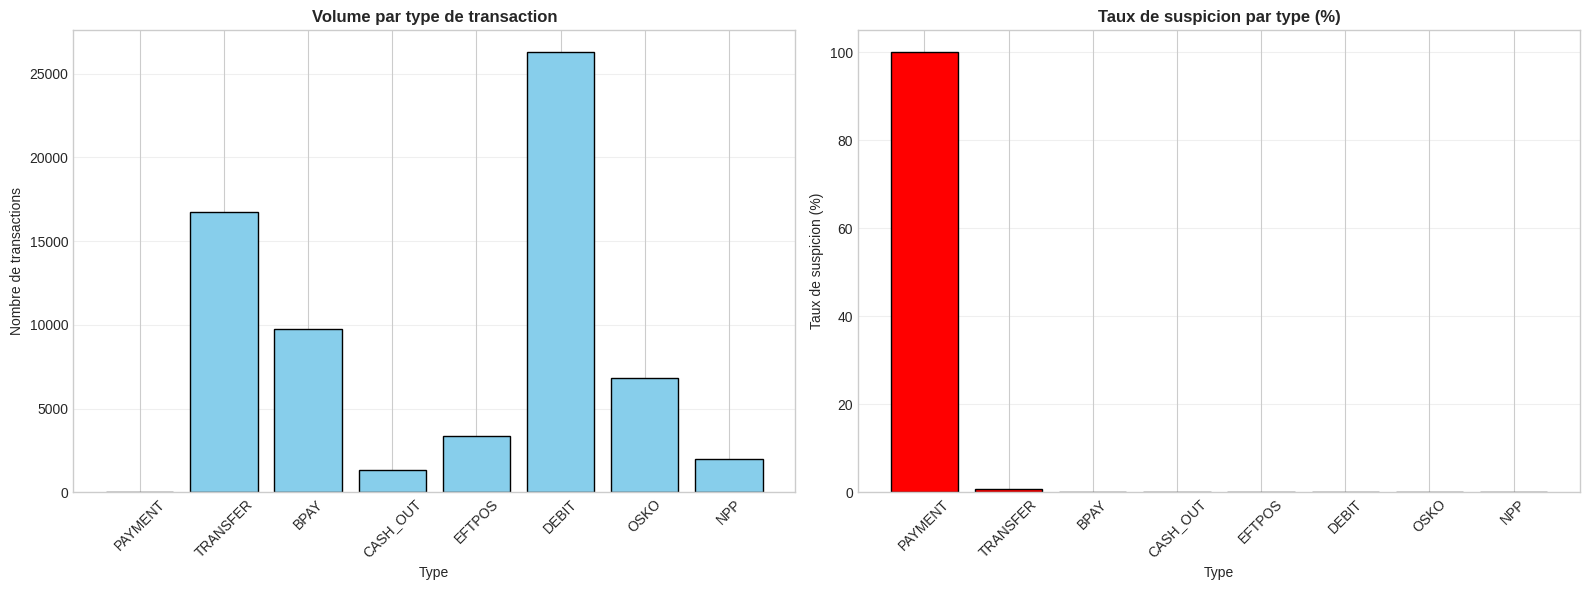

In [78]:
# ============================================================
# 3.4. Analyse des types de transactions
# ============================================================

print("\n" + "-" * 60)
print("3.4. ANALYSE DES TYPES DE TRANSACTIONS")
print("-" * 60)

if 'type' in df.columns:
    # Analyse par type
    type_analysis = df.groupby('type').agg({
        target_col: ['count', 'sum', 'mean']
    }).round(4)
    type_analysis.columns = ['Total', 'Suspectes', 'Taux_Suspicion']
    type_analysis['Taux_Suspicion_Pct'] = type_analysis['Taux_Suspicion'] * 100
    type_analysis = type_analysis.sort_values('Taux_Suspicion', ascending=False)

    print("📊 Analyse par type de transaction :")
    display(type_analysis)

    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Volume par type
    axes[0].bar(type_analysis.index, type_analysis['Total'], color='skyblue', edgecolor='black')
    axes[0].set_title('Volume par type de transaction', fontweight='bold')
    axes[0].set_xlabel('Type')
    axes[0].set_ylabel('Nombre de transactions')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Taux de suspicion par type
    colors = ['red' if x > type_analysis['Taux_Suspicion_Pct'].median() else 'orange'
              for x in type_analysis['Taux_Suspicion_Pct']]
    axes[1].bar(type_analysis.index, type_analysis['Taux_Suspicion_Pct'],
                color=colors, edgecolor='black')
    axes[1].set_title('Taux de suspicion par type (%)', fontweight='bold')
    axes[1].set_xlabel('Type')
    axes[1].set_ylabel('Taux de suspicion (%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


------------------------------------------------------------
3.5. ANALYSE DES TYPOLOGIES DE BLANCHIMENT
------------------------------------------------------------
📊 Top 10 des typologies de blanchiment :


,count
category,
Other,120
Recreation,21
Shell Company,4
Property Investment,1


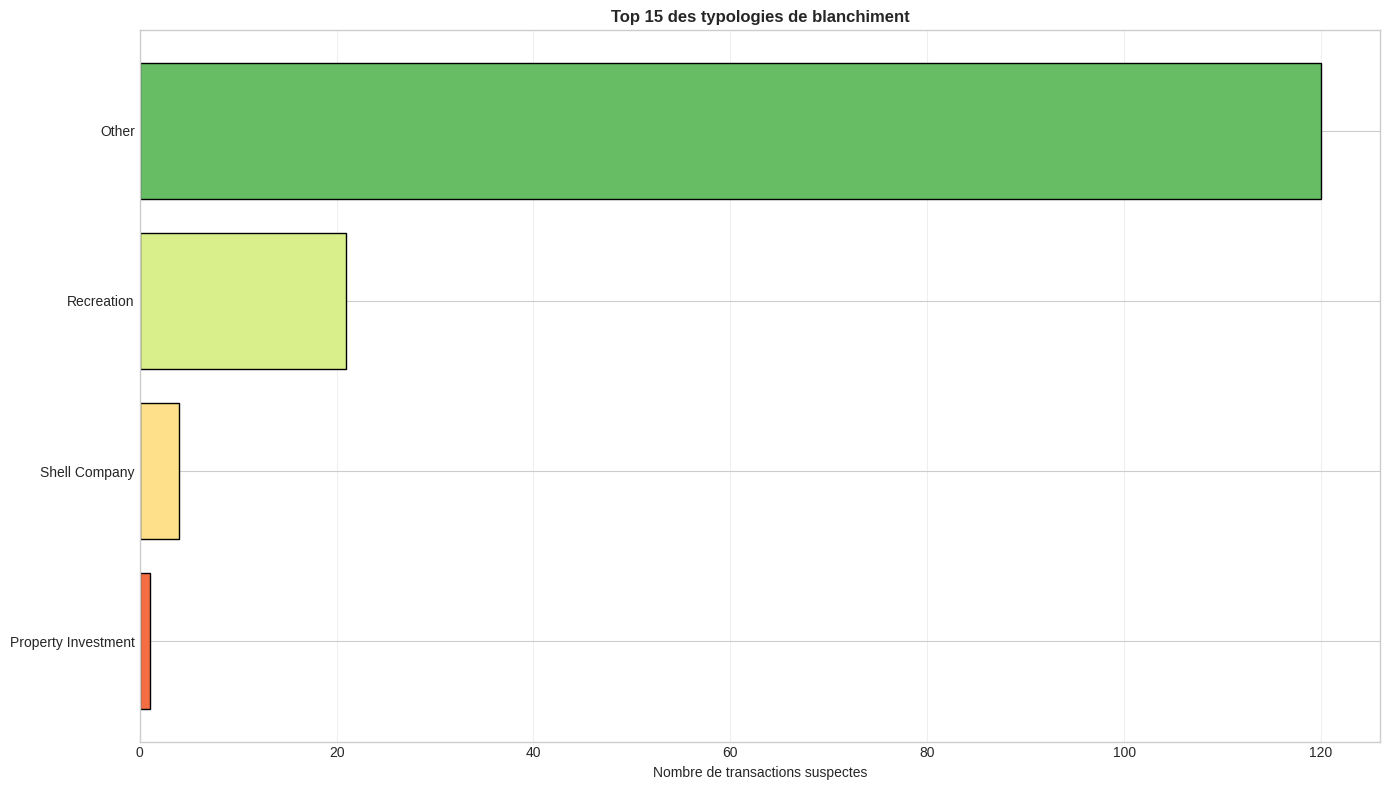


    PRINCIPALES TYPOLOGIES IDENTIFIÉES :
    -----------------------------------
    • Structuring (Mule) : Transactions structurées pour éviter les seuils
    • Layered_Fan_In/Out : Transactions en éventail pour brouiller les pistes
    • Scatter-Gather : Dispersion puis concentration de fonds
    • Normal_* : Transactions normales avec patterns suspects
    


In [79]:
# ============================================================
# 3.5. Analyse des typologies de blanchiment
# ============================================================

print("\n" + "-" * 60)
print("3.5. ANALYSE DES TYPOLOGIES DE BLANCHIMENT")
print("-" * 60)

if 'category' in df.columns:
    # Analyse des typologies
    category_analysis = df[df[target_col] == 1]['category'].value_counts()

    print("📊 Top 10 des typologies de blanchiment :")
    display(category_analysis.head(10))

    # Visualisation
    plt.figure(figsize=(14, 8))

    top15 = category_analysis.head(15)
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top15)))

    plt.barh(range(len(top15)), top15.values, color=colors, edgecolor='black')
    plt.yticks(range(len(top15)), top15.index)
    plt.xlabel('Nombre de transactions suspectes')
    plt.title('Top 15 des typologies de blanchiment', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("""
    PRINCIPALES TYPOLOGIES IDENTIFIÉES :
    -----------------------------------
    • Structuring (Mule) : Transactions structurées pour éviter les seuils
    • Layered_Fan_In/Out : Transactions en éventail pour brouiller les pistes
    • Scatter-Gather : Dispersion puis concentration de fonds
    • Normal_* : Transactions normales avec patterns suspects
    """)


------------------------------------------------------------
3.6. MATRICE DE CORRÉLATION
------------------------------------------------------------


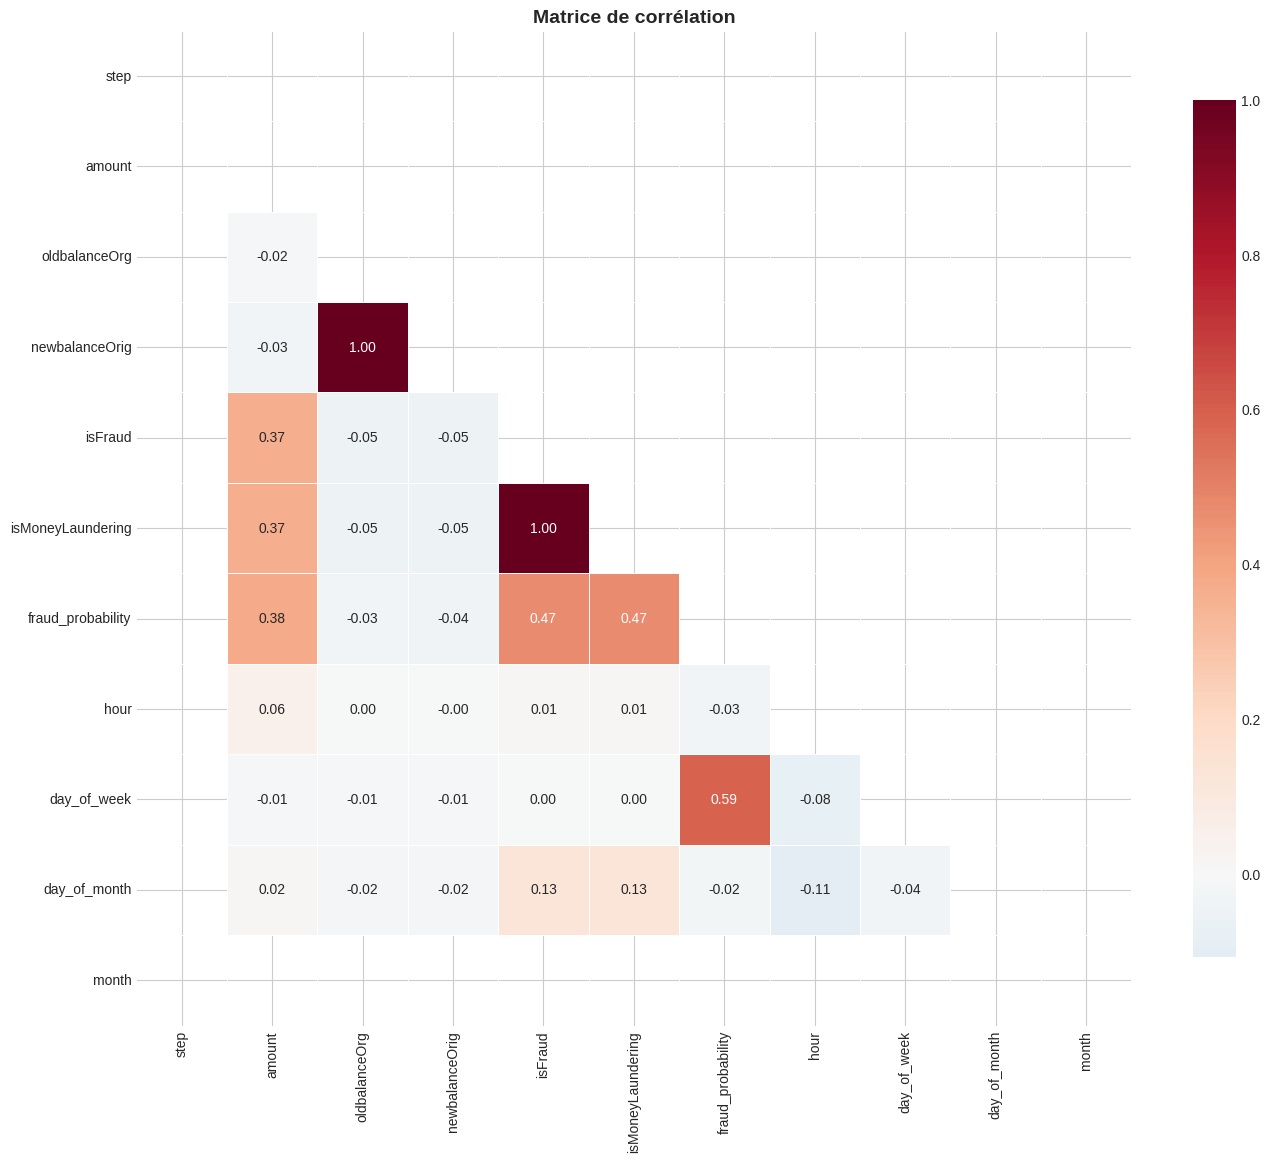


📊 Corrélations avec isMoneyLaundering :


,Variable,Corrélation
1,isFraud,1.0000
2,fraud_probability,0.4747
3,amount,0.3670
4,day_of_month,0.1278
5,hour,0.0103
6,day_of_week,0.0012
7,oldbalanceOrg,-0.0482
8,newbalanceOrig,-0.0547
9,step,NaN
10,month,NaN



🔍 VARIABLES LES PLUS CORRÉLÉES :
  1. isFraud : 1.000
  2. fraud_probability : 0.475
  3. amount : 0.367
  4. day_of_month : 0.128
  5. hour : 0.010


In [80]:
# ============================================================
# 3.6. Matrice de corrélation
# ============================================================

print("\n" + "-" * 60)
print("3.6. MATRICE DE CORRÉLATION")
print("-" * 60)

# Sélection des colonnes numériques
corr_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns]
corr_matrix = df[corr_cols].corr()

# Visualisation
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Corrélations avec la cible
target_corr = corr_matrix[target_col].sort_values(ascending=False)
print(f"\n📊 Corrélations avec {target_col} :")
target_corr_df = pd.DataFrame({
    'Variable': target_corr.index,
    'Corrélation': target_corr.values
})
target_corr_df = target_corr_df[target_corr_df['Variable'] != target_col]
display(target_corr_df.head(10))

print("\n🔍 VARIABLES LES PLUS CORRÉLÉES :")
for i in range(min(5, len(target_corr_df))):
    var = target_corr_df.iloc[i]
    print(f"  {i+1}. {var['Variable']} : {var['Corrélation']:.3f}")

In [81]:
# ============================================================
# 4. PRÉTRAITEMENT ET FEATURE ENGINEERING
# ============================================================

print("\n" + "=" * 80)
print("4. PRÉTRAITEMENT ET FEATURE ENGINEERING")
print("=" * 80)


4. PRÉTRAITEMENT ET FEATURE ENGINEERING


In [83]:
# ============================================================
# 4.1. Création de nouvelles features
# ============================================================

print("\n" + "-" * 60)
print("4.1. CRÉATION DE NOUVELLES FEATURES")
print("-" * 60)

df_model = df.copy()

# 1. Features de solde
print("✓ Création des features de solde...")
df_model['balance_change_orig'] = df_model['oldbalanceOrg'] - df_model['newbalanceOrig']
# df_model['balance_change_dest'] = df_model['newbalanceDest'] - df_model['oldbalanceDest'] # Ces colonnes sont manquantes
df_model['balance_ratio_orig'] = df_model['newbalanceOrig'] / (df_model['oldbalanceOrg'] + 1)
# df_model['balance_ratio_dest'] = df_model['newbalanceDest'] / (df_model['oldbalanceDest'] + 1) # Ces colonnes sont manquantes
df_model['is_zero_balance_orig'] = (df_model['oldbalanceOrg'] == 0).astype(int)

# 2. Features de montant
print("✓ Création des features de montant...")
df_model['amount_log'] = np.log1p(df_model['amount'])
df_model['amount_sqrt'] = np.sqrt(df_model['amount'])
df_model['is_round_amount'] = (df_model['amount'] == df_model['amount'].round(0)).astype(int)
df_model['amount_vs_balance'] = df_model['amount'] / (df_model['oldbalanceOrg'] + 1)

# 3. Features temporelles avancées
print("✓ Création des features temporelles...")
if 'hour' in df_model.columns:
    df_model['is_night'] = ((df_model['hour'] >= 22) | (df_model['hour'] <= 5)).astype(int)
    df_model['is_business_hours'] = ((df_model['hour'] >= 9) & (df_model['hour'] <= 17)).astype(int)

if 'day_of_week' in df_model.columns:
    df_model['is_weekend'] = df_model['day_of_week'].isin([5, 6]).astype(int)

# 4. Features d'interaction
print("✓ Création des features d'interaction...")
if 'type' in df_model.columns and 'amount' in df_model.columns:
    # One-hot encoding du type
    type_dummies = pd.get_dummies(df_model['type'], prefix='type')
    df_model = pd.concat([df_model, type_dummies], axis=1)

    # Interaction type × amount
    for t in df_model['type'].unique():
        df_model[f'amount_type_{t}'] = df_model['amount'] * (df_model['type'] == t)

print(f"\n✅ Features créées : {df_model.shape[1] - df.shape[1]} nouvelles colonnes")
print(f"📊 Nombre total de features : {df_model.shape[1]}")


------------------------------------------------------------
4.1. CRÉATION DE NOUVELLES FEATURES
------------------------------------------------------------
✓ Création des features de solde...
✓ Création des features de montant...
✓ Création des features temporelles...
✓ Création des features d'interaction...

✅ Features créées : 26 nouvelles colonnes
📊 Nombre total de features : 43


In [95]:
# ============================================================
# 4.2. Préparation des données
# ============================================================

print("\n" + "-" * 60)
print("4.2. PRÉPARATION DES DONNÉES")
print("-" * 60)

# Identification des colonnes à exclure
# Ajout de 'isFraud' à la liste des colonnes à exclure pour éviter la fuite de données
exclude_cols = ['nameOrig', 'nameDest', 'category', 'isFraud']  # Identifiants, colonnes non numériques et la variable 'isFraud'
feature_cols = [col for col in df_model.columns
                if col not in exclude_cols
                and col != target_col
                and df_model[col].dtype in ['int64', 'float64', 'bool']]

print(f"📋 Features sélectionnées : {len(feature_cols)}")

# Séparation features/cible
X = df_model[feature_cols]
y = df_model[target_col]

# Gestion des valeurs infinies
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"\n📊 Dimensions finales :")
print(f"  • X : {X.shape[0]:,} lignes × {X.shape[1]} colonnes")
print(f"  • y : {y.shape[0]:,} lignes")
print(f"  • Ratio de classes : {y.mean():.4%} de suspects")


------------------------------------------------------------
4.2. PRÉPARATION DES DONNÉES
------------------------------------------------------------
📋 Features sélectionnées : 35

📊 Dimensions finales :
  • X : 66,224 lignes × 35 colonnes
  • y : 66,224 lignes
  • Ratio de classes : 0.2205% de suspects


In [88]:
# ============================================================
# 4.3. Split temporel et standardisation
# ============================================================

print("\n" + "-" * 60)
print("4.3. SPLIT TEMPOREL ET STANDARDISATION")
print("-" * 60)

# Suppression des lignes avec NaN dans y (variable cible)
initial_len = len(y)
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]
print(f"⚠️ {initial_len - len(y)} lignes supprimées en raison de NaN dans la variable cible '{target_col}'.")

# Split temporel si step disponible
# Vérification si 'step' est une colonne appropriée pour le split temporel (contient plus d'une valeur unique)
if 'step' in df_model.columns and df_model['step'].nunique() > 1:
    # Utiliser step comme proxy temporel
    split_step = df_model['step'].quantile(0.8)
    train_idx = df_model['step'] <= split_step
    test_idx = df_model['step'] > split_step

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
else:
    print("\n⚠️ La colonne 'step' n'est pas adaptée pour un split temporel ou est manquante. Utilisation du split aléatoire stratifié.")
    # Split aléatoire stratifié
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"📊 Distribution des ensembles :")
print(f"  • Train : {len(X_train):,} transactions ({y_train.mean():.4%} suspects)")
print(f"  • Test  : {len(X_test):,} transactions ({y_test.mean():.4%} suspects)")

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Standardisation effectuée")


------------------------------------------------------------
4.3. SPLIT TEMPOREL ET STANDARDISATION
------------------------------------------------------------
⚠️ 1 lignes supprimées en raison de NaN dans la variable cible 'isMoneyLaundering'.

⚠️ La colonne 'step' n'est pas adaptée pour un split temporel ou est manquante. Utilisation du split aléatoire stratifié.
📊 Distribution des ensembles :
  • Train : 52,978 transactions (0.2208% suspects)
  • Test  : 13,245 transactions (0.2190% suspects)

✅ Standardisation effectuée


In [90]:
# ============================================================
# 4.4. Gestion du déséquilibre avec SMOTE
# ============================================================

print("\n" + "-" * 60)
print("4.4. GESTION DU DÉSÉQUILIBRE AVEC SMOTE")
print("-" * 60)

# Test de différentes stratégies
print("📊 Comparaison des stratégies de rééchantillonnage :")

# 1. SMOTE standard
smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"  • SMOTE (ratio 1:10) : {y_train_smote.mean():.4%} suspects")

# 2. SMOTE + Tomek
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_scaled, y_train)
print(f"  • SMOTE + Tomek     : {y_train_smt.mean():.4%} suspects")

# 3. ADASYN (désactivé en raison de l'erreur 'Not any neigbours belong to the majority class')
# adasyn = ADASYN(random_state=42, sampling_strategy=0.1)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
# print(f"  • ADASYN            : {y_train_adasyn.mean():.4%} suspects")

print("\n✅ Stratégies de rééchantillonnage configurées")


------------------------------------------------------------
4.4. GESTION DU DÉSÉQUILIBRE AVEC SMOTE
------------------------------------------------------------
📊 Comparaison des stratégies de rééchantillonnage :
  • SMOTE (ratio 1:10) : 9.0908% suspects
  • SMOTE + Tomek     : 50.0000% suspects

✅ Stratégies de rééchantillonnage configurées


In [91]:
# ============================================================
# 5. MODÉLISATION ET OPTIMISATION
# ============================================================

print("\n" + "=" * 80)
print("5. MODÉLISATION ET OPTIMISATION")
print("=" * 80)


5. MODÉLISATION ET OPTIMISATION


In [92]:
# ============================================================
# 5.1. Configuration de la validation croisée
# ============================================================

print("\n" + "-" * 60)
print("5.1. CONFIGURATION DE LA VALIDATION CROISÉE")
print("-" * 60)

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"📊 Configuration :")
print(f"  • {n_folds} folds")
print(f"  • Stratification maintenue")
print(f"  • Shuffle activé")

# Fonction d'évaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Évalue un modèle et retourne les métriques"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    return {
        'Modèle': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

results = {}


------------------------------------------------------------
5.1. CONFIGURATION DE LA VALIDATION CROISÉE
------------------------------------------------------------
📊 Configuration :
  • 5 folds
  • Stratification maintenue
  • Shuffle activé


In [94]:
# ============================================================
# 5.2. Entraînement des modèles de base
# ============================================================

print("\n" + "-" * 60)
print("5.2. ENTRAÎNEMENT DES MODÈLES DE BASE")
print("-" * 60)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Scale pos weight : {scale_pos_weight:.2f}")

# 1. RÉGRESSION LOGISTIQUE
print("\n" + "=" * 40)
print("1. RÉGRESSION LOGISTIQUE")
print("=" * 40)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1)
results['LogisticRegression'] = evaluate_model(
    lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Régression Logistique'
)
print(f"  • Recall : {results['LogisticRegression']['Recall']:.4f}")
print(f"  • F1     : {results['LogisticRegression']['F1-Score']:.4f}")

# 2. ARBRE DE DÉCISION
print("\n" + "=" * 40)
print("2. ARBRE DE DÉCISION")
print("=" * 40)

dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
results['DecisionTree'] = evaluate_model(
    dt, X_train_scaled, y_train, X_test_scaled, y_test, 'Arbre de Décision'
)
print(f"  • Recall : {results['DecisionTree']['Recall']:.4f}")
print(f"  • F1     : {results['DecisionTree']['F1-Score']:.4f}")

# 3. RANDOM FOREST
print("\n" + "=" * 40)
print("3. RANDOM FOREST")
print("=" * 40)

rf = RandomForestClassifier(
    n_estimators=100, max_depth=15, min_samples_split=50,
    class_weight='balanced', random_state=42, n_jobs=-1
)
results['RandomForest'] = evaluate_model(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest'
)
print(f"  • Recall : {results['RandomForest']['Recall']:.4f}")
print(f"  • F1     : {results['RandomForest']['F1-Score']:.4f}")

# 4. XGBOOST
print("\n" + "=" * 40)
print("4. XGBOOST")
print("=" * 40)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
results['XGBoost'] = evaluate_model(
    xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost'
)
print(f"  • Recall : {results['XGBoost']['Recall']:.4f}")
print(f"  • F1     : {results['XGBoost']['F1-Score']:.4f}")

# 5. GRADIENT BOOSTING
print("\n" + "=" * 40)
print("5. GRADIENT BOOSTING")
print("=" * 40)

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
results['GradientBoosting'] = evaluate_model(
    gb, X_train_scaled, y_train, X_test_scaled, y_test, 'Gradient Boosting'
)
print(f"  • Recall : {results['GradientBoosting']['Recall']:.4f}")
print(f"  • F1     : {results['GradientBoosting']['F1-Score']:.4f}")


------------------------------------------------------------
5.2. ENTRAÎNEMENT DES MODÈLES DE BASE
------------------------------------------------------------
⚖️ Scale pos weight : 451.80

1. RÉGRESSION LOGISTIQUE
  • Recall : 1.0000
  • F1     : 1.0000

2. ARBRE DE DÉCISION
  • Recall : 1.0000
  • F1     : 1.0000

3. RANDOM FOREST
  • Recall : 1.0000
  • F1     : 1.0000

4. XGBOOST
  • Recall : 1.0000
  • F1     : 1.0000

5. GRADIENT BOOSTING
  • Recall : 1.0000
  • F1     : 1.0000


In [96]:
# ============================================================
# 4.3. Split temporel et standardisation
# ============================================================

print("\n" + "-" * 60)
print("4.3. SPLIT TEMPOREL ET STANDARDISATION")
print("-" * 60)

# Suppression des lignes avec NaN dans y (variable cible)
initial_len = len(y)
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]
print(f"⚠️ {initial_len - len(y)} lignes supprimées en raison de NaN dans la variable cible '{target_col}'.")

# Split temporel si step disponible
# Vérification si 'step' est une colonne appropriée pour le split temporel (contient plus d'une valeur unique)
if 'step' in df_model.columns and df_model['step'].nunique() > 1:
    # Utiliser step comme proxy temporel
    split_step = df_model['step'].quantile(0.8)
    train_idx = df_model['step'] <= split_step
    test_idx = df_model['step'] > split_step

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
else:
    print("\n⚠️ La colonne 'step' n'est pas adaptée pour un split temporel ou est manquante. Utilisation du split aléatoire stratifié.")
    # Split aléatoire stratifié
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"📊 Distribution des ensembles :")
print(f"  • Train : {len(X_train):,} transactions ({y_train.mean():.4%} suspects)")
print(f"  • Test  : {len(X_test):,} transactions ({y_test.mean():.4%} suspects)")

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Standardisation effectuée")


------------------------------------------------------------
4.3. SPLIT TEMPOREL ET STANDARDISATION
------------------------------------------------------------
⚠️ 1 lignes supprimées en raison de NaN dans la variable cible 'isMoneyLaundering'.

⚠️ La colonne 'step' n'est pas adaptée pour un split temporel ou est manquante. Utilisation du split aléatoire stratifié.
📊 Distribution des ensembles :
  • Train : 52,978 transactions (0.2208% suspects)
  • Test  : 13,245 transactions (0.2190% suspects)

✅ Standardisation effectuée


In [97]:
# ============================================================
# 4.4. Gestion du déséquilibre avec SMOTE
# ============================================================

print("\n" + "-" * 60)
print("4.4. GESTION DU DÉSÉQUILIBRE AVEC SMOTE")
print("-" * 60)

# Test de différentes stratégies
print("📊 Comparaison des stratégies de rééchantillonnage :")

# 1. SMOTE standard
smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"  • SMOTE (ratio 1:10) : {y_train_smote.mean():.4%} suspects")

# 2. SMOTE + Tomek
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_scaled, y_train)
print(f"  • SMOTE + Tomek     : {y_train_smt.mean():.4%} suspects")

# 3. ADASYN (désactivé en raison de l'erreur 'Not any neigbours belong to the majority class')
# adasyn = ADASYN(random_state=42, sampling_strategy=0.1)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
# print(f"  • ADASYN            : {y_train_adasyn.mean():.4%} suspects")

print("\n✅ Stratégies de rééchantillonnage configurées")


------------------------------------------------------------
4.4. GESTION DU DÉSÉQUILIBRE AVEC SMOTE
------------------------------------------------------------
📊 Comparaison des stratégies de rééchantillonnage :
  • SMOTE (ratio 1:10) : 9.0908% suspects
  • SMOTE + Tomek     : 50.0000% suspects

✅ Stratégies de rééchantillonnage configurées


In [ ]:
# ============================================================
# 5.2. Entraînement des modèles de base
# ============================================================

print("\n" + "-" * 60)
print("5.2. ENTRAÎNEMENT DES MODÈLES DE BASE")
print("-" * 60)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Scale pos weight : {scale_pos_weight:.2f}")

# 1. RÉGRESSION LOGISTIQUE
print("\n" + "=" * 40)
print("1. RÉGRESSION LOGISTIQUE")
print("=" * 40)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1)
results['LogisticRegression'] = evaluate_model(
    lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Régression Logistique'
)
print(f"  • Recall : {results['LogisticRegression']['Recall']:.4f}")
print(f"  • F1     : {results['LogisticRegression']['F1-Score']:.4f}")

# 2. ARBRE DE DÉCISION
print("\n" + "=" * 40)
print("2. ARBRE DE DÉCISION")
print("=" * 40)

dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
results['DecisionTree'] = evaluate_model(
    dt, X_train_scaled, y_train, X_test_scaled, y_test, 'Arbre de Décision'
)
print(f"  • Recall : {results['DecisionTree']['Recall']:.4f}")
print(f"  • F1     : {results['DecisionTree']['F1-Score']:.4f}")

# 3. RANDOM FOREST
print("\n" + "=" * 40)
print("3. RANDOM FOREST")
print("=" * 40)

rf = RandomForestClassifier(
    n_estimators=100, max_depth=15, min_samples_split=50,
    class_weight='balanced', random_state=42, n_jobs=-1
)
results['RandomForest'] = evaluate_model(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest'
)
print(f"  • Recall : {results['RandomForest']['Recall']:.4f}")
print(f"  • F1     : {results['RandomForest']['F1-Score']:.4f}")

# 4. XGBOOST
print("\n" + "=" * 40)
print("4. XGBOOST")
print("=" * 40)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
results['XGBoost'] = evaluate_model(
    xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost'
)
print(f"  • Recall : {results['XGBoost']['Recall']:.4f}")
print(f"  • F1     : {results['XGBoost']['F1-Score']:.4f}")

# 5. GRADIENT BOOSTING
print("\n" + "=" * 40)
print("5. GRADIENT BOOSTING")
print("=" * 40)

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
results['GradientBoosting'] = evaluate_model(
    gb, X_train_scaled, y_train, X_test_scaled, y_test, 'Gradient Boosting'
)
print(f"  • Recall : {results['GradientBoosting']['Recall']:.4f}")
print(f"  • F1     : {results['GradientBoosting']['F1-Score']:.4f}")


------------------------------------------------------------
5.2. ENTRAÎNEMENT DES MODÈLES DE BASE
------------------------------------------------------------
⚖️ Scale pos weight : 451.80

1. RÉGRESSION LOGISTIQUE
  • Recall : 1.0000
  • F1     : 0.3021

2. ARBRE DE DÉCISION
  • Recall : 0.7931
  • F1     : 0.6571

3. RANDOM FOREST
  • Recall : 0.8276
  • F1     : 0.7500

4. XGBOOST
  • Recall : 0.9655
  • F1     : 0.9032

5. GRADIENT BOOSTING
